
# Damaged Building Classification Using Multiple Models

Connecting the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Libraries

In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import timm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
from glob import glob
from pathlib import Path
from osgeo import gdal
import pickle
import random


Checking libraries

In [24]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 2.0.2
Pandas version 2.2.2


[link text](https://https://www.kaggle.com/datasets/turkertuncer/turkiye-earthquake-2023-damaged-buildings)# Classification on Turkey Dataset

Code for loading Custom Dataset (RS data)

In [ ]:
from torch.utils.data import Dataset
from glob import glob
from pathlib import Path
import numpy as np
import os
import cv2

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, img_transform=None):
        self.img_dir = img_dir
        self.img_transform = img_transform

        self.image_files = sorted(
            glob(os.path.join(self.img_dir, "**", "*.[jJpP][pPnN][gG]"), recursive=True)
        )
        print(f"Found {len(self.image_files)} image files.")  # Debug line

        sub_folders = sorted(
            class_name for class_name in os.listdir(self.img_dir)
            if os.path.isdir(os.path.join(self.img_dir, class_name))
        )
        self.sub_folder_dict = {class_name: index for index, class_name in enumerate(sub_folders)}

    def __len__(self):  
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32) / 255.0

        if self.img_transform:
            image = self.img_transform(image)

        label = self.sub_folder_dict[Path(img_path).parts[-2]]
        return image, label


In [46]:
data_path = r"/content/drive/MyDrive/turkey"
data = CustomImageDataset(data_path)


Found 2735 image files.


Randomly selecting training data from the dataset, Using 30 percent of the total dataset.

In [47]:
# using random seed so we get the same random set everytime
random.seed("seed1")
samplesize = int(0.3 * len(data))

print(f"****Random Sample Data****\nselecting 30% from the dataset of {len(data)}\nSample size for training is {samplesize}\n")
sampleidx = random.sample(range(len(data)), samplesize)
print(f"***Randomly sampled {samplesize} indices from dataset***\n{sampleidx}")


****Random Sample Data****
selecting 30% from the dataset of 2735
Sample size for training is 820

***Randomly sampled 820 indices from dataset***
[709, 2041, 2599, 1401, 1570, 1002, 1960, 1372, 2187, 279, 81, 946, 421, 332, 834, 147, 121, 2727, 771, 2062, 50, 189, 1073, 1725, 2387, 1225, 2662, 800, 1487, 1553, 510, 1993, 200, 1686, 907, 966, 1140, 2082, 1078, 1787, 625, 634, 2267, 1468, 289, 1139, 275, 405, 140, 1910, 413, 546, 725, 462, 2272, 1625, 1486, 1733, 1383, 82, 2079, 1492, 1183, 324, 2262, 813, 1293, 1659, 2567, 1737, 132, 2423, 1278, 931, 2026, 798, 1509, 2544, 2215, 2679, 1803, 1267, 1579, 812, 3, 674, 2450, 1421, 299, 601, 2190, 1658, 2035, 418, 1860, 2181, 1525, 1286, 2405, 1123, 1474, 982, 2300, 1491, 1863, 555, 1821, 836, 1049, 699, 452, 923, 551, 1334, 1400, 1912, 2308, 904, 2730, 2436, 177, 1833, 2418, 647, 561, 815, 1751, 1005, 1097, 1206, 2692, 2589, 616, 1168, 574, 570, 2072, 492, 1671, 2649, 1404, 95, 741, 2135, 1323, 536, 106, 1163, 130, 1220, 517, 66, 1819, 260

In [48]:
print(type(data))
sample_data = [data[i] for i in tqdm(sampleidx, desc="Sampling data")]


<class '__main__.CustomImageDataset'>


Sampling data:   0%|          | 0/820 [00:00<?, ?it/s]

In [ ]:
# image, _ = sample_data[0]
# print(image.shape)
# print(range(image.shape[0])) basically the same thing as num_bands below.

In [49]:
num_bands = sample_data[0][0].shape[0] #number of bands  in the sampled data
print(f"Number of bands in the sampled data: {num_bands}")

#Creating an empty list to flatten and store the bands
flatnBandList=[]
flatnBandList = [[] for i in range(num_bands)]
print(flatnBandList)

# Loop over each sample in the dataset
for sample in tqdm(sample_data, desc="Flattening and Storing Bands"):
    image, _ = sample  # unpack image and ignore label
    for i in range(num_bands):
        flatnBandList[i].append(image[i].flatten())
print(len(flatnBandList))

Number of bands in the sampled data: 3
[[], [], []]


Flattening and Storing Bands:   0%|          | 0/820 [00:00<?, ?it/s]

3


In [50]:
means = []
stds = []
abs_means = []
abs_stds = []

for band_values in flatnBandList:
    # Convert each array in the band to a float32 tensor
    tensors = [torch.tensor(arr, dtype=torch.float32) for arr in band_values]

    # Concatenate all tensors into one long 1D tensor
    all_pixels = torch.cat(tensors)

    # Compute raw mean and std
    means.append(all_pixels.mean().item())
    stds.append(all_pixels.std().item())

    # Compute absolute mean and std (optional, if required)
    abs_pixels = torch.abs(all_pixels)
    abs_means.append(abs_pixels.mean().item())
    abs_stds.append(abs_pixels.std().item())

print("Band-wise means:", means)
print("Band-wise stds:", stds)
print("Absolute Band-wise means:", abs_means)
print("Absolute Band-wise stds:", abs_stds)

stats = {
    "means": means,
    "stds": stds
}

# Save to file
with open("band_stats.pkl", "wb") as f:
    pickle.dump(stats, f)

with open("band_stats.pkl", "rb") as f:
    loaded_stats = pickle.load(f)

print(f"Band Stat Pickle file loaded successfully. Loaded stats: {loaded_stats}")


Band-wise means: [0.4789222478866577, 0.4283447563648224, 0.4114004075527191]
Band-wise stds: [0.25686490535736084, 0.21574766933918, 0.20375175774097443]
Absolute Band-wise means: [0.4789222478866577, 0.4283447563648224, 0.4114004075527191]
Absolute Band-wise stds: [0.25686490535736084, 0.21574766933918, 0.20375175774097443]
Band Stat Pickle file loaded successfully. Loaded stats: {'means': [0.4789222478866577, 0.4283447563648224, 0.4114004075527191], 'stds': [0.25686490535736084, 0.21574766933918, 0.20375175774097443]}


Custom Transformation

In [51]:
from torchvision.transforms import v2

class CustomAugmentation:
    def __init__(self, resize_size=(256, 256), crop_size=(224, 224),
                 do_resize=True, do_random_crop=True, do_horizontal_flip=True, do_random_hue=True):
        self.resize_size = resize_size
        self.crop_size = crop_size
        self.do_resize = do_resize
        self.do_random_crop = do_random_crop
        self.do_horizontal_flip = do_horizontal_flip
        self.do_random_hue = do_random_hue

    def __call__(self, image):
        if self.do_resize:
            image = v2.functional.resize(image, self.resize_size, antialias=True)

        if self.do_random_crop:
            _, height, width = image.shape
            crop_height, crop_width = self.crop_size
            top = torch.randint(0, height - crop_height + 1, (1,)).item()
            left = torch.randint(0, width - crop_width + 1, (1,)).item()
            image = v2.functional.crop(image, top, left, crop_height, crop_width)

        if self.do_horizontal_flip and torch.rand(1) > 0.5:
            image = v2.functional.horizontal_flip(image)

        if self.do_random_hue and torch.rand(1) > 0.5 and image.shape[0] >= 3:
            image[:3] = v2.functional.adjust_hue(image[:3], torch.empty(1).uniform_(-0.1, 0.1).item())

        return image




Z Score Normalization
`

In [52]:
# Load from pickle
with open("band_stats.pkl", "rb") as f:
    loaded_stats = pickle.load(f)

class z_score_form_stats:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1) #(C,W,H)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def __call__(self, image):
        return (image - self.mean) / (self.std + 1e-6)

# Final transformation pipeline
custom_transform = transforms.Compose([
    lambda x: torch.from_numpy(x).float(),
    CustomAugmentation(resize_size=(256, 256), crop_size=(224, 224), do_random_hue=False),
    z_score_form_stats(mean=loaded_stats["means"], std=loaded_stats["stds"])
])


In [53]:
# Apply the final transform to full dataset
data_path =r"/content/drive/MyDrive/turkey"

mydataset_full = CustomImageDataset(data_path, img_transform=custom_transform) #, sensor='rgb'
print(len(mydataset_full))
print(mydataset_full[1])

# Split sizes
train_size = int(0.7 * len(mydataset_full))
val_size   = int(0.1 * len(mydataset_full))
test_size  = len(mydataset_full) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(mydataset_full, [train_size, val_size, test_size])

# Save paths
train_paths = [mydataset_full.image_files[i] for i in train_dataset.indices]
val_paths   = [mydataset_full.image_files[i] for i in val_dataset.indices]
test_paths  = [mydataset_full.image_files[i] for i in test_dataset.indices]


splits_dict = {
    "train_paths": train_paths,
    "val_paths": val_paths,
    "test_paths": test_paths
}

with open("splits.pkl", "wb") as f:
    pickle.dump(splits_dict, f)

# To reload:
with open("splits.pkl", "rb") as f:
    loaded_splits = pickle.load(f)

print("Train:", len(loaded_splits["train_paths"]))
print("Validation:", len(loaded_splits["val_paths"]))
print("Test:", len(loaded_splits["test_paths"]))


Found 2735 image files.
2735
(tensor([[[-0.5685, -0.5474, -0.5478,  ..., -1.1446, -1.1622, -1.1280],
         [-0.6019, -0.5638, -0.5541,  ..., -1.0369, -1.1018, -1.1004],
         [-0.6347, -0.6019, -0.5983,  ..., -1.1151, -1.1800, -1.1982],
         ...,
         [ 0.2330,  0.2529,  0.2719,  ...,  1.2854,  1.3176,  1.3188],
         [ 0.2795,  0.2945,  0.3049,  ...,  1.2956,  1.3256,  1.3300],
         [ 0.3182,  0.3244,  0.3277,  ...,  1.2902,  1.3280,  1.3311]],

        [[-0.4591, -0.4231, -0.4177,  ..., -1.0411, -1.0734, -1.0358],
         [-0.4733, -0.4338, -0.4253,  ..., -0.9246, -1.0041, -1.0030],
         [-0.4661, -0.4562, -0.4673,  ..., -1.0205, -1.0978, -1.1194],
         ...,
         [ 0.5300,  0.5537,  0.5763,  ...,  1.8314,  1.8459,  1.8409],
         [ 0.5853,  0.6032,  0.6156,  ...,  1.8435,  1.8554,  1.8543],
         [ 0.6314,  0.6388,  0.6427,  ...,  1.8370,  1.8584,  1.8556]],

        [[-0.3941, -0.3366, -0.3207,  ..., -0.9615, -0.9957, -0.9559],
         [-0.42

**********************************************************************
*********************************************************************
***********************************************************************

# Assignment 1: Using Timm to train a classification model

In [57]:
import timm

model = timm.create_model("resnet50", pretrained=False, num_classes=2)
model = model.to(device)


# import timm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=2)
# model.to(device)


##Training and Validation


🔁 Training model: resnet18
Epoch 1/20 - Train Loss: 0.4792, Val Loss: 0.2944 - Time: 23.14s
Epoch 2/20 - Train Loss: 0.1965, Val Loss: 0.1309 - Time: 23.62s
Epoch 3/20 - Train Loss: 0.1112, Val Loss: 0.0871 - Time: 23.65s
Epoch 4/20 - Train Loss: 0.0752, Val Loss: 0.0747 - Time: 24.01s
Epoch 5/20 - Train Loss: 0.0598, Val Loss: 0.0655 - Time: 23.52s
Epoch 6/20 - Train Loss: 0.0437, Val Loss: 0.0550 - Time: 24.45s
Epoch 7/20 - Train Loss: 0.0405, Val Loss: 0.0560 - Time: 23.97s
Epoch 8/20 - Train Loss: 0.0367, Val Loss: 0.0531 - Time: 23.56s
Epoch 9/20 - Train Loss: 0.0248, Val Loss: 0.0634 - Time: 23.58s
Epoch 10/20 - Train Loss: 0.0159, Val Loss: 0.0611 - Time: 22.96s
Epoch 11/20 - Train Loss: 0.0236, Val Loss: 0.0613 - Time: 23.65s
Epoch 12/20 - Train Loss: 0.0162, Val Loss: 0.0559 - Time: 23.68s
Epoch 13/20 - Train Loss: 0.0108, Val Loss: 0.0504 - Time: 23.68s
Epoch 14/20 - Train Loss: 0.0168, Val Loss: 0.0623 - Time: 23.71s
Epoch 15/20 - Train Loss: 0.0114, Val Loss: 0.0619 - Time

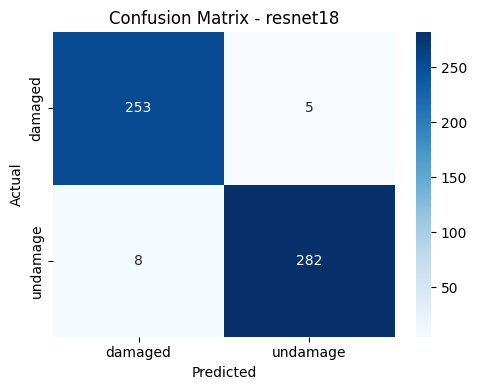

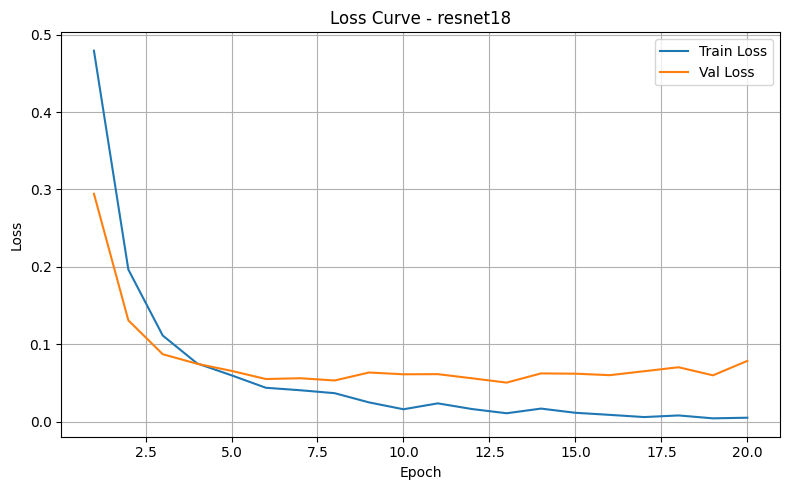

⏱️ Total time for resnet18: 479.24 seconds

🔁 Training model: resnet50
Epoch 1/20 - Train Loss: 0.5303, Val Loss: 0.3062 - Time: 36.12s
Epoch 2/20 - Train Loss: 0.2183, Val Loss: 0.1075 - Time: 35.82s
Epoch 3/20 - Train Loss: 0.0925, Val Loss: 0.0702 - Time: 36.16s
Epoch 4/20 - Train Loss: 0.0701, Val Loss: 0.0613 - Time: 36.90s
Epoch 5/20 - Train Loss: 0.0478, Val Loss: 0.0569 - Time: 36.55s
Epoch 6/20 - Train Loss: 0.0398, Val Loss: 0.0610 - Time: 36.31s
Epoch 7/20 - Train Loss: 0.0322, Val Loss: 0.0471 - Time: 36.87s
Epoch 8/20 - Train Loss: 0.0249, Val Loss: 0.0531 - Time: 36.85s
Epoch 9/20 - Train Loss: 0.0265, Val Loss: 0.0424 - Time: 36.80s
Epoch 10/20 - Train Loss: 0.0154, Val Loss: 0.0513 - Time: 36.99s
Epoch 11/20 - Train Loss: 0.0168, Val Loss: 0.0470 - Time: 36.24s
Epoch 12/20 - Train Loss: 0.0134, Val Loss: 0.0402 - Time: 36.54s
Epoch 13/20 - Train Loss: 0.0098, Val Loss: 0.0446 - Time: 36.63s
Epoch 14/20 - Train Loss: 0.0095, Val Loss: 0.0568 - Time: 36.70s
Epoch 15/20 - 

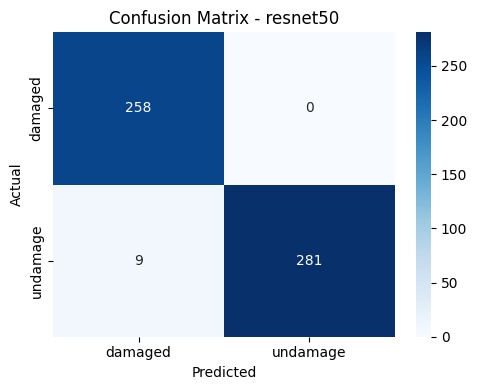

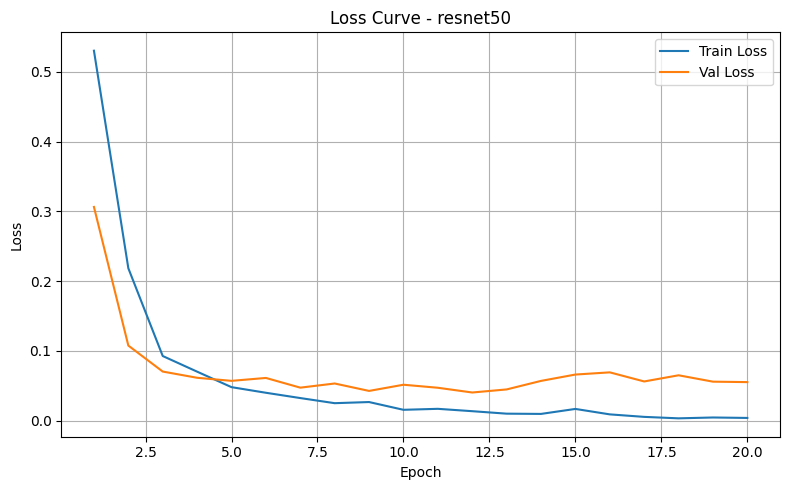

⏱️ Total time for resnet50: 738.96 seconds

🔁 Training model: efficientnet_b0
Epoch 1/20 - Train Loss: 0.2742, Val Loss: 0.1060 - Time: 26.76s
Epoch 2/20 - Train Loss: 0.0578, Val Loss: 0.1508 - Time: 26.73s
Epoch 3/20 - Train Loss: 0.0296, Val Loss: 0.2126 - Time: 27.02s
Epoch 4/20 - Train Loss: 0.0229, Val Loss: 0.2033 - Time: 27.02s
Epoch 5/20 - Train Loss: 0.0190, Val Loss: 0.1244 - Time: 26.79s
Epoch 6/20 - Train Loss: 0.0123, Val Loss: 0.1156 - Time: 26.86s
Epoch 7/20 - Train Loss: 0.0067, Val Loss: 0.1427 - Time: 26.98s
Epoch 8/20 - Train Loss: 0.0021, Val Loss: 0.1179 - Time: 27.34s
Epoch 9/20 - Train Loss: 0.0087, Val Loss: 0.1814 - Time: 27.22s
Epoch 10/20 - Train Loss: 0.0014, Val Loss: 0.1741 - Time: 27.47s
Epoch 11/20 - Train Loss: 0.0011, Val Loss: 0.2015 - Time: 27.57s
Epoch 12/20 - Train Loss: 0.0036, Val Loss: 0.1684 - Time: 27.71s
Epoch 13/20 - Train Loss: 0.0199, Val Loss: 0.1531 - Time: 27.06s
Epoch 14/20 - Train Loss: 0.0039, Val Loss: 0.1365 - Time: 27.13s
Epoch 1

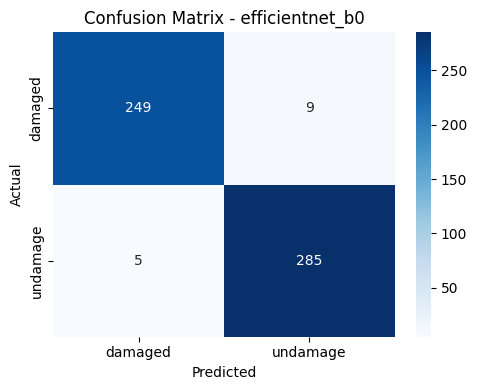

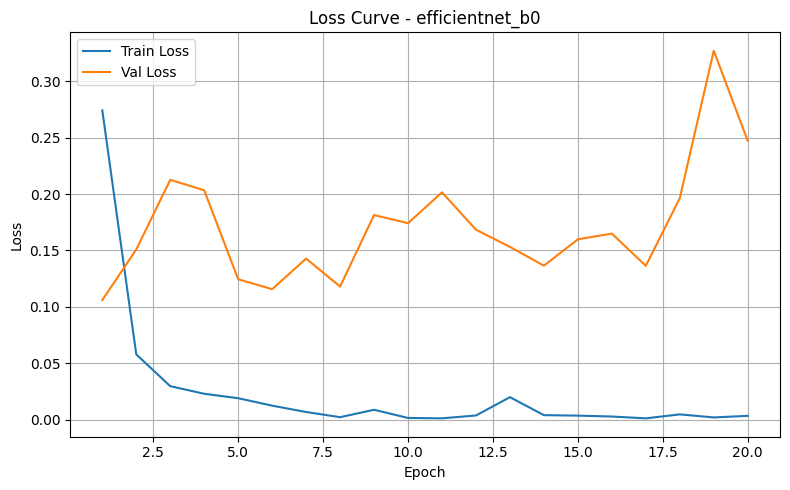

⏱️ Total time for efficientnet_b0: 548.69 seconds

🔁 Training model: mobilenetv3_large_100
Epoch 1/20 - Train Loss: 0.2907, Val Loss: 0.1770 - Time: 23.26s
Epoch 2/20 - Train Loss: 0.0688, Val Loss: 0.2831 - Time: 22.92s
Epoch 3/20 - Train Loss: 0.0350, Val Loss: 0.2006 - Time: 23.33s
Epoch 4/20 - Train Loss: 0.0190, Val Loss: 0.2379 - Time: 23.44s
Epoch 5/20 - Train Loss: 0.0347, Val Loss: 0.2700 - Time: 23.23s
Epoch 6/20 - Train Loss: 0.0050, Val Loss: 0.1446 - Time: 23.10s
Epoch 7/20 - Train Loss: 0.0077, Val Loss: 0.1192 - Time: 23.66s
Epoch 8/20 - Train Loss: 0.0239, Val Loss: 0.1438 - Time: 23.72s
Epoch 9/20 - Train Loss: 0.0588, Val Loss: 0.2066 - Time: 23.74s
Epoch 10/20 - Train Loss: 0.0170, Val Loss: 0.1200 - Time: 23.04s
Epoch 11/20 - Train Loss: 0.0177, Val Loss: 0.1505 - Time: 24.65s
Epoch 12/20 - Train Loss: 0.0036, Val Loss: 0.1537 - Time: 23.29s
Epoch 13/20 - Train Loss: 0.0014, Val Loss: 0.1867 - Time: 23.48s
Epoch 14/20 - Train Loss: 0.0037, Val Loss: 0.1304 - Time: 2

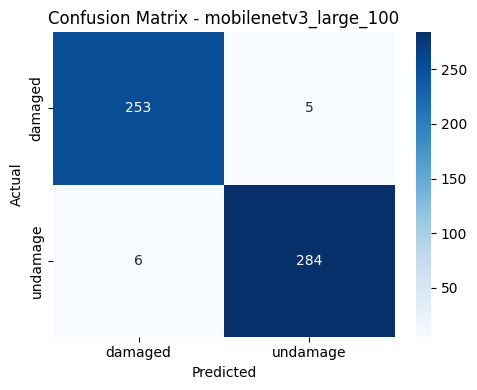

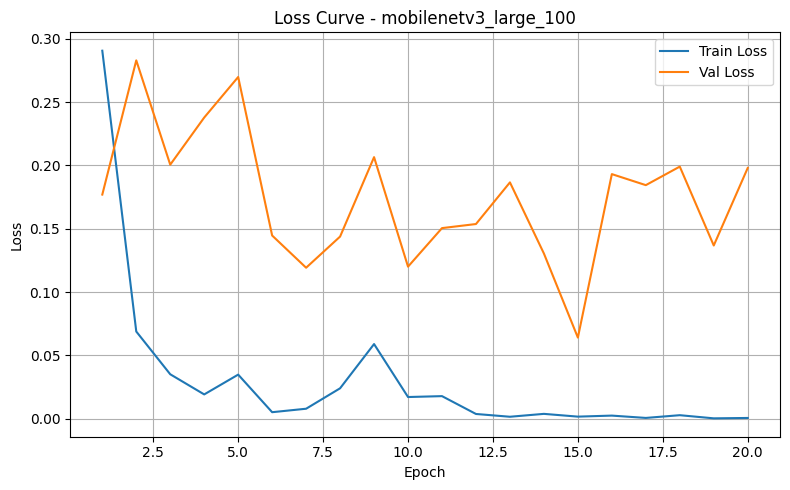

⏱️ Total time for mobilenetv3_large_100: 472.86 seconds

🔁 Training model: vit_base_patch16_224
Epoch 1/20 - Train Loss: 0.1461, Val Loss: 0.0938 - Time: 79.74s
Epoch 2/20 - Train Loss: 0.0390, Val Loss: 0.0831 - Time: 80.09s
Epoch 3/20 - Train Loss: 0.0637, Val Loss: 0.0841 - Time: 79.51s
Epoch 4/20 - Train Loss: 0.0238, Val Loss: 0.0476 - Time: 80.02s
Epoch 5/20 - Train Loss: 0.0428, Val Loss: 0.0477 - Time: 79.77s
Epoch 6/20 - Train Loss: 0.0147, Val Loss: 0.0561 - Time: 79.68s
Epoch 7/20 - Train Loss: 0.0165, Val Loss: 0.0848 - Time: 80.01s
Epoch 8/20 - Train Loss: 0.0220, Val Loss: 0.0614 - Time: 79.67s
Epoch 9/20 - Train Loss: 0.0214, Val Loss: 0.0965 - Time: 79.63s
Epoch 10/20 - Train Loss: 0.0108, Val Loss: 0.0336 - Time: 80.03s
Epoch 11/20 - Train Loss: 0.0089, Val Loss: 0.0688 - Time: 79.84s
Epoch 12/20 - Train Loss: 0.0028, Val Loss: 0.1219 - Time: 79.92s
Epoch 13/20 - Train Loss: 0.0172, Val Loss: 0.0890 - Time: 80.09s
Epoch 14/20 - Train Loss: 0.0038, Val Loss: 0.1814 - Ti

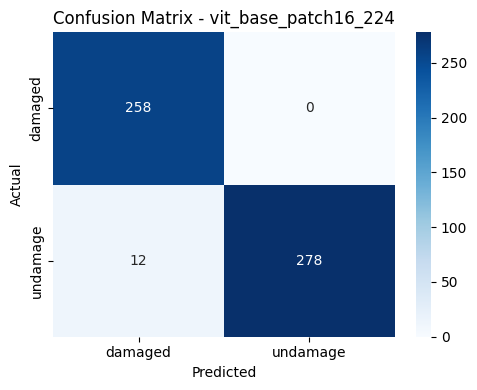

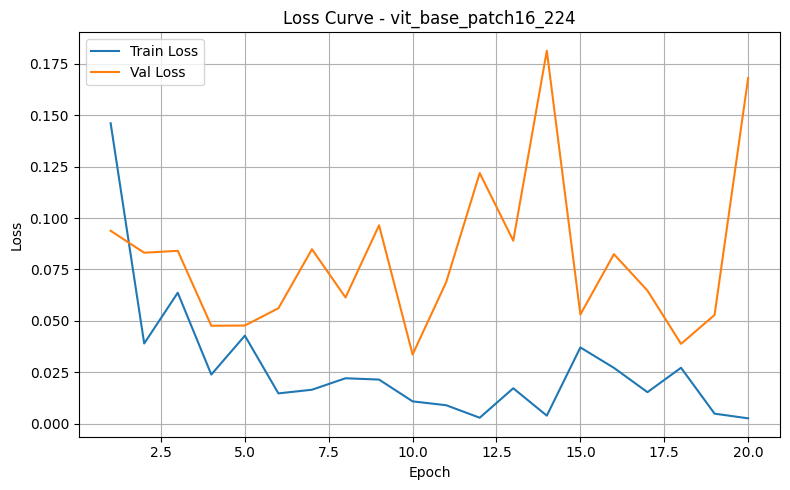

⏱️ Total time for vit_base_patch16_224: 1610.18 seconds


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import pickle
import time  # for tracking time

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model list
model_names = [
    "resnet18",
    "resnet50",
    "efficientnet_b0",
    "mobilenetv3_large_100",
    "vit_base_patch16_224"
]

# Training settings
num_epochs = 20
class_names = ["damaged", "undamage"]

for model_name in model_names:
    print(f"\n🔁 Training model: {model_name}")
    model_start_time = time.time()

    model = timm.create_model(model_name, pretrained=True, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} - Time: {epoch_time:.2f}s")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), f"{model_name}_best.pth")
    print(f"✅ Best model saved: {model_name}_best.pth")

    with open(f"{model_name}_losses.pkl", "wb") as f:
        pickle.dump({"train": train_losses, "val": val_losses}, f)

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n📊 Classification Report for {model_name}:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    model_total_time = time.time() - model_start_time
    print(f"⏱️ Total time for {model_name}: {model_total_time:.2f} seconds")



📸 Visualizing predictions for: resnet18


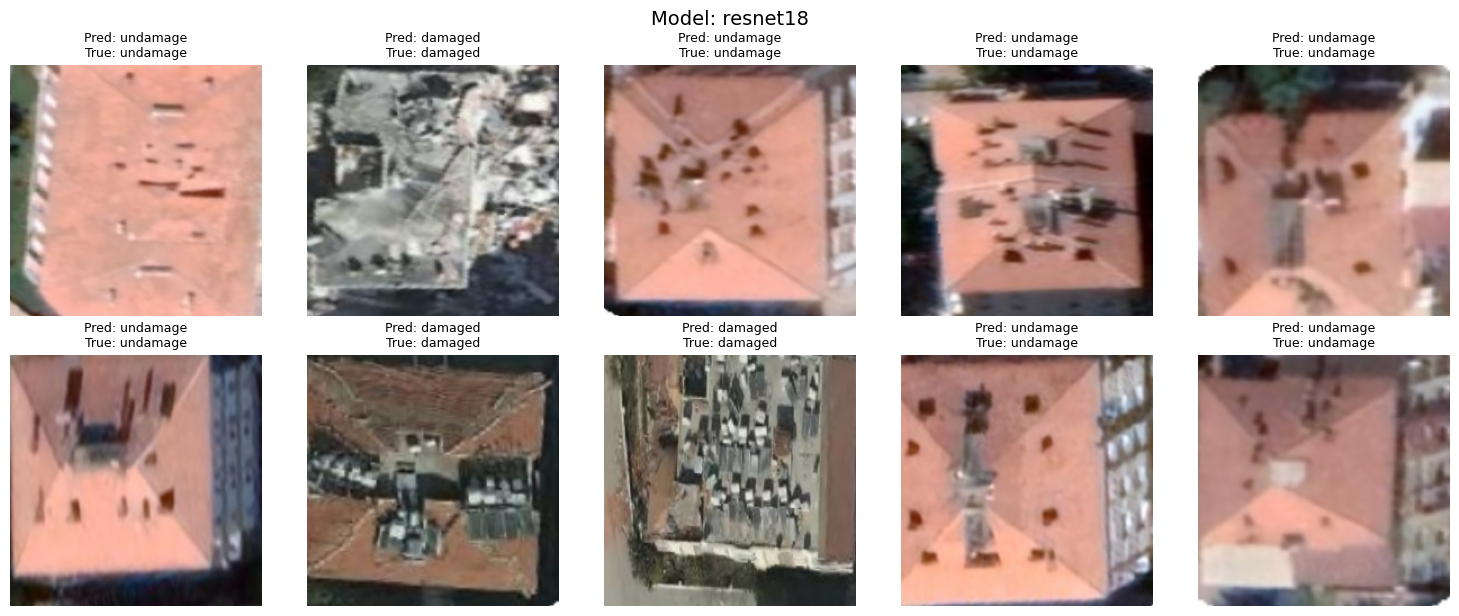


📸 Visualizing predictions for: resnet50


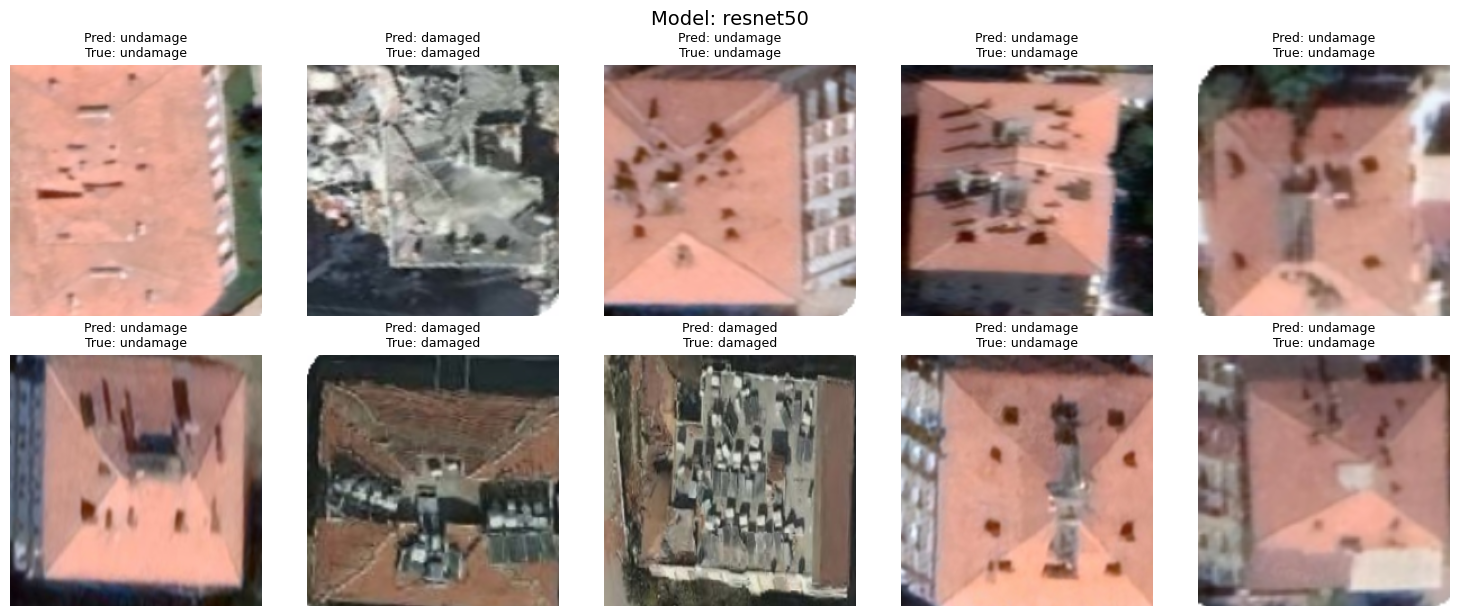


📸 Visualizing predictions for: efficientnet_b0


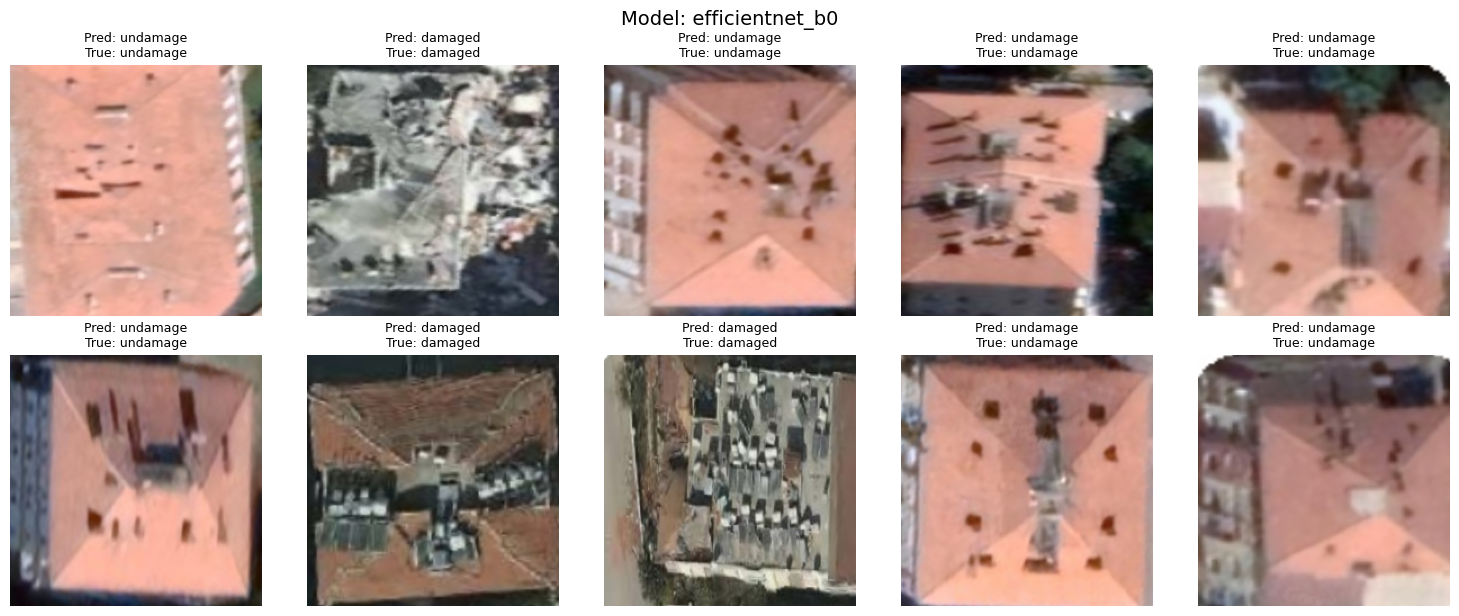


📸 Visualizing predictions for: mobilenetv3_large_100


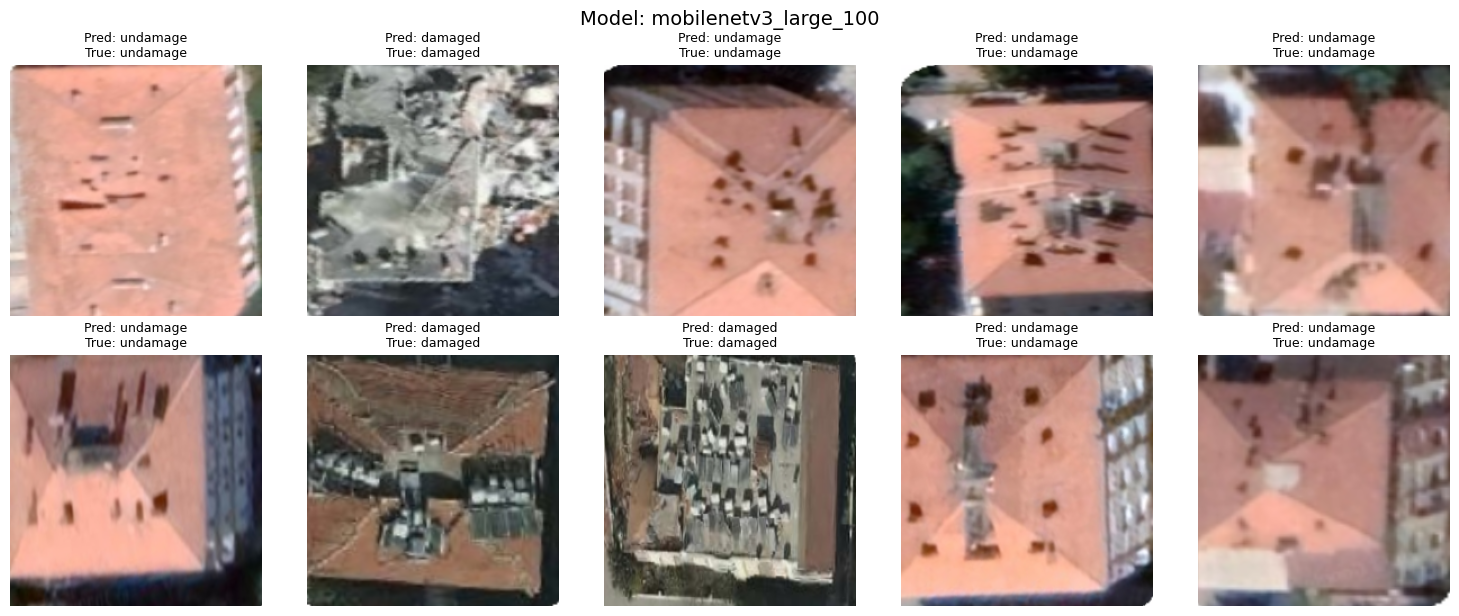


📸 Visualizing predictions for: vit_base_patch16_224


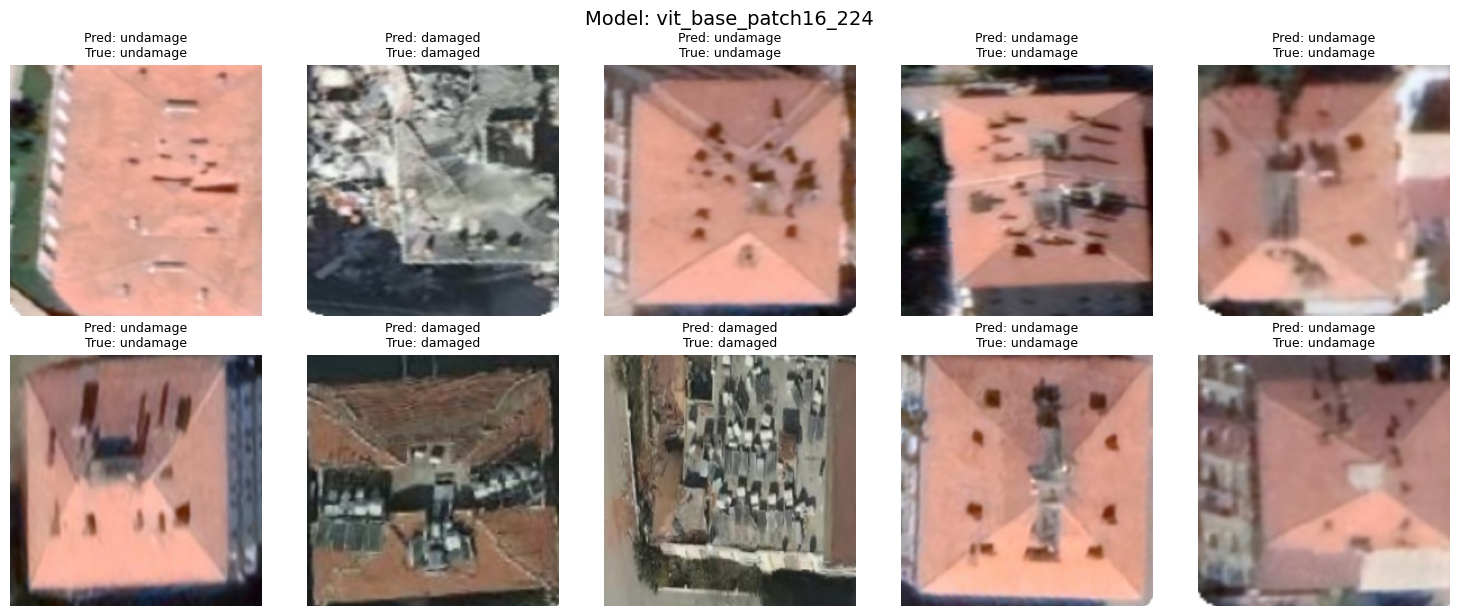

In [71]:
import matplotlib.pyplot as plt
import torch
import timm
import torchvision.transforms as T

# Class names
class_names = ["damaged", "undamage"]

# Un-normalize (if using z-score normalization)
def unnormalize(img_tensor):
    mean = torch.tensor([0.4789, 0.4283, 0.4114]).view(-1, 1, 1)
    std = torch.tensor([0.2569, 0.2157, 0.2038]).view(-1, 1, 1)
    return img_tensor * std + mean

# Model list
model_names = [
    "resnet18",
    "resnet50",
    "efficientnet_b0",
    "mobilenetv3_large_100",
    "vit_base_patch16_224"
]

# Grid config
rows, cols = 2, 5  # 10 images per model

# Loop through each model
for model_name in model_names:
    print(f"\n📸 Visualizing predictions for: {model_name}")

    # Load the model and its weights
    model = timm.create_model(model_name, pretrained=False, num_classes=2).to(device)
    model.load_state_dict(torch.load(f"{model_name}_best.pth"))
    model.eval()

    # Start grid
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    shown = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if shown >= rows * cols:
                    break

                img = unnormalize(images[i].cpu()).clamp(0, 1)
                img_np = img.permute(1, 2, 0).numpy()
                row, col = divmod(shown, cols)
                ax = axes[row, col]
                ax.imshow(img_np)
                ax.axis('off')
                ax.set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}", fontsize=9)

                shown += 1
            if shown >= rows * cols:
                break

    plt.tight_layout()
    plt.suptitle(f"Model: {model_name}", fontsize=14, y=1.02)
    plt.show()
